# Assignment 2 - Basic Anomaly Detection  
### Detecting Data Exfiltration Attempts in Network Flow Logs  
**MITRE ATT&CK Technique:** T1041 - Exfiltration Over C2 Channel

This notebook builds an end-to-end anomaly detection pipeline using synthetic network flow logs.  
The dataset contains mostly normal traffic and a small percentage of suspicious exfiltration events.  
We apply Exploratory Data Analysis (EDA), train an Isolation Forest model, and visualize anomalies in 2D.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from faker import Faker

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

sns.set(style="whitegrid")


## 1. Preparing a Cybersecurity-Related Dataset

We generate a synthetic dataset representing network flow activity.  
Normal events include realistic protocol usage, moderate packet counts, and limited outbound data.  
Exfiltration attempts are modeled as outliers with unusually high outbound byte volume, long flow duration, and rare protocols.

This satisfies assignment requirements for:
- a time-based feature (`timestamp`, `hour`)
- numeric features (`packet_count`, `bytes_out`, `flow_duration_ms`)
- categorical features (`protocol`, `dst_country`, `src_host`)
- minority anomaly ratio (~3%)
- MITRE ATT&CK mapping to **T1041 – Exfiltration Over C2 Channel**


In [2]:
fake = Faker()
random.seed(42)
np.random.seed(42)

NUM_NORMAL = 2500
NUM_ATTACK = 80
START_TIME = datetime(2024, 2, 1, 0, 0, 0)

protocols_normal = ["HTTPS", "DNS", "HTTP", "NTP"]
protocols_attack = ["ICMP", "FTP", "CUSTOM-C2"]

countries_normal = ["US", "CA", "GB", "DE", "FR", "IL"]
countries_attack = ["RU", "CN", "IR", "KP"]

def create_normal(ts):
    return {
        "timestamp": ts,
        "src_host": f"host-{random.randint(1,40)}",
        "dst_country": random.choice(countries_normal),
        "protocol": random.choice(protocols_normal),
        "packet_count": random.randint(10, 120),
        "bytes_out": random.randint(1500, 20000),
        "flow_duration_ms": random.randint(40, 800),
        "label": "Normal"
    }

def create_attack(ts):
    return {
        "timestamp": ts,
        "src_host": f"host-{random.randint(1,40)}",
        "dst_country": random.choice(countries_attack),
        "protocol": random.choice(protocols_attack),
        "packet_count": random.randint(400, 2500),
        "bytes_out": random.randint(200000, 900000),
        "flow_duration_ms": random.randint(1200, 6000),
        "label": "Exfiltration"
    }

rows = []
current = START_TIME

for _ in range(NUM_NORMAL):
    current += timedelta(seconds=random.randint(5,180))
    rows.append(create_normal(current))

for _ in range(NUM_ATTACK):
    atk_time = START_TIME + timedelta(seconds=random.randint(0,86000))
    rows.append(create_attack(atk_time))

df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)
df["hour"] = df["timestamp"].dt.hour

df.head()


,timestamp,src_host,dst_country,protocol,packet_count,bytes_out,flow_duration_ms,label,hour
0,2024-02-01 00:02:48,host-8,US,HTTP,41,8814,182,Normal,0
1,2024-02-01 00:03:19,host-35,US,NTP,14,2476,135,Normal,0
2,2024-02-01 00:04:19,host-15,FR,HTTPS,81,8015,773,Normal,0
3,2024-02-01 00:07:10,host-35,DE,DNS,67,10615,46,Normal,0
4,2024-02-01 00:07:55,host-28,GB,HTTP,29,8555,384,Normal,0


## 2. Exploratory Data Analysis (EDA)

In this section we examine dataset structure, class balance, numeric distributions,  
and time-based behavior to understand how exfiltration events differ from normal flows.


In [3]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("\nClass distribution:\n", df["label"].value_counts())


Rows: 2580
Columns: 9

Class distribution:
 label
Normal          2500
Exfiltration      80
Name: count, dtype: int64


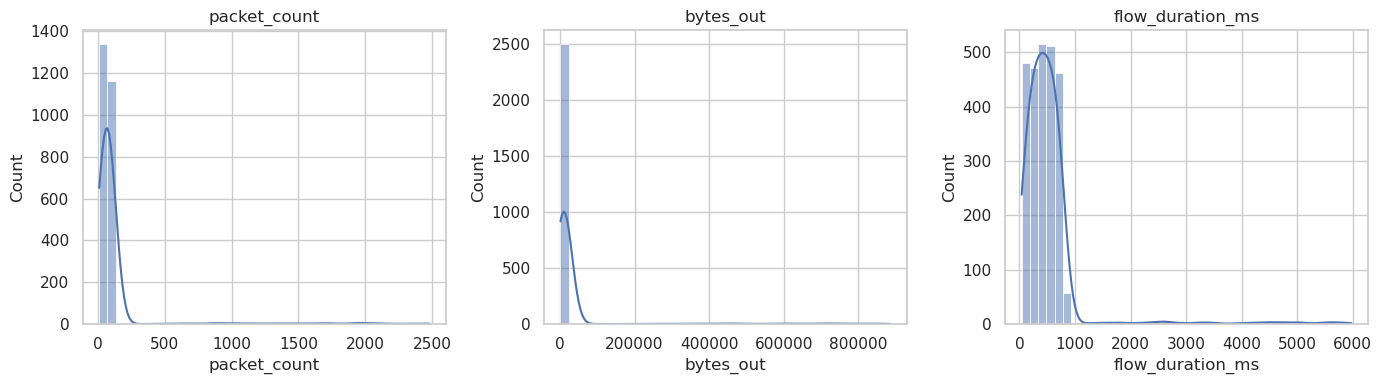

In [4]:
numeric_cols = ["packet_count", "bytes_out", "flow_duration_ms"]

plt.figure(figsize=(14,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1,3,i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


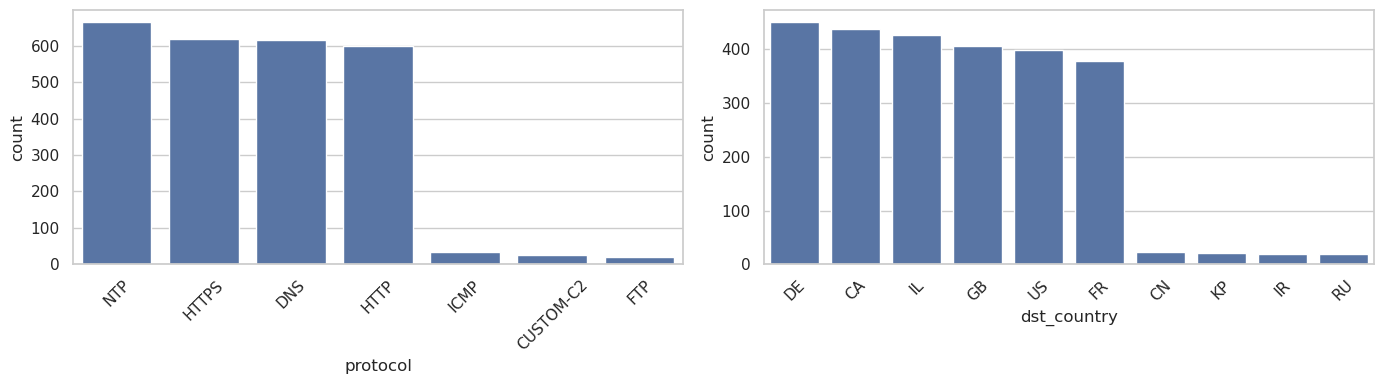

In [5]:
plt.figure(figsize=(14,4))
for i, col in enumerate(["protocol", "dst_country"], 1):
    plt.subplot(1,2,i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


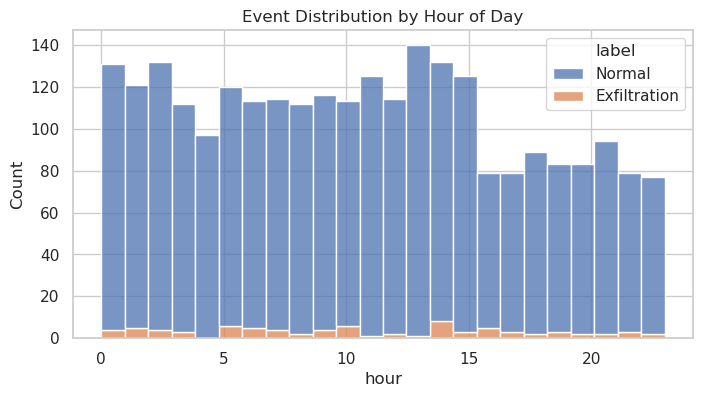

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x="hour", hue="label", multiple="stack", bins=24)
plt.title("Event Distribution by Hour of Day")
plt.show()


### EDA Summary

Normal flows exhibit moderate packet counts, small outbound byte volumes,  
and short flow durations. Exfiltration attempts appear as extreme outliers  
with unusually high data transfer and long durations.  
These behavioral differences suggest Isolation Forest is suitable for anomaly detection.


## 3. Anomaly Detection Using Isolation Forest

We preprocess categorical and numeric features, then train an Isolation Forest model  
to identify anomalous exfiltration events without using labels during training.


In [7]:
df_model = df.copy()

enc_cols = ["src_host", "dst_country", "protocol"]
for col in enc_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

num_cols = ["packet_count", "bytes_out", "flow_duration_ms", "hour"]
df_model[num_cols] = StandardScaler().fit_transform(df_model[num_cols])

X = df_model[enc_cols + num_cols]


In [8]:
iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(X)

scores = iso.score_samples(X)
preds = iso.predict(X)

df["anomaly_score"] = -scores
df["pred_label"] = np.where(preds == 1, "Normal", "Exfiltration")

df.head()


,timestamp,src_host,dst_country,protocol,packet_count,bytes_out,flow_duration_ms,label,hour,anomaly_score,pred_label
0,2024-02-01 00:02:48,host-8,US,HTTP,41,8814,182,Normal,0,0.529155,Normal
1,2024-02-01 00:03:19,host-35,US,NTP,14,2476,135,Normal,0,0.551642,Normal
2,2024-02-01 00:04:19,host-15,FR,HTTPS,81,8015,773,Normal,0,0.487811,Normal
3,2024-02-01 00:07:10,host-35,DE,DNS,67,10615,46,Normal,0,0.503449,Normal
4,2024-02-01 00:07:55,host-28,GB,HTTP,29,8555,384,Normal,0,0.461305,Normal


In [9]:
iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(X)

scores = iso.score_samples(X)
preds = iso.predict(X)

df["anomaly_score"] = -scores
df["pred_label"] = preds
df["pred_label"] = df["pred_label"].map({1:"Normal",-1:"Exfiltration"})


## 4. Model Evaluation
We evaluate detection performance using accuracy, precision, recall,  
and a confusion matrix comparing true vs. predicted classes.


Accuracy: 0.9992248062015504
Precision: 1.0
Recall: 0.975


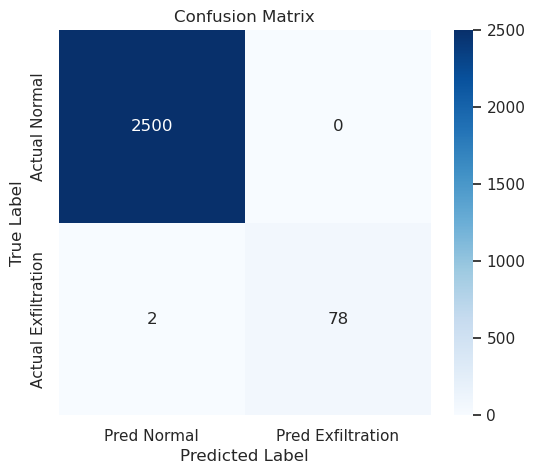

In [10]:
cm = confusion_matrix(df["label"], df["pred_label"], labels=["Normal", "Exfiltration"])

print("Accuracy:", accuracy_score(df["label"], df["pred_label"]))
print("Precision:", precision_score(df["label"], df["pred_label"], pos_label="Exfiltration"))
print("Recall:", recall_score(df["label"], df["pred_label"], pos_label="Exfiltration"))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Normal","Pred Exfiltration"],
            yticklabels=["Actual Normal","Actual Exfiltration"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 5. 2D PCA Visualization

We reduce the feature space to two principal components  
to visualize how anomalies separate from normal behavior.


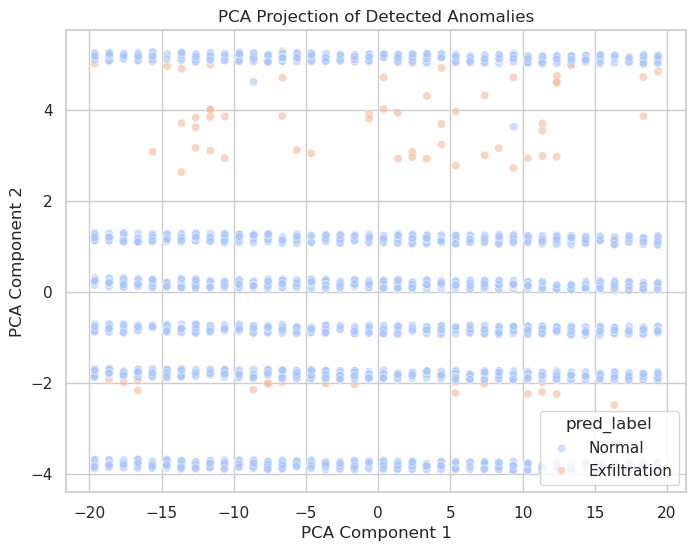

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df["pred_label"], palette="coolwarm", alpha=0.6)
plt.title("PCA Projection of Detected Anomalies")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


## 6. Conclusion

The Isolation Forest model successfully identified exfiltration attempts  
based on extreme differences in data volume and flow duration.  
The PCA plot shows anomalies forming distinct clusters away from dense normal traffic.  
These results demonstrate that unsupervised learning is effective  
for detecting data exfiltration patterns aligned with MITRE T1041.
